In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

In [2]:
# Load dataset and basic exploration
columns = ["Age", "Sex", "BMI", "Children", "Smoker", "Region", "Charges"]
df = pd.read_csv("Medical-Insurance.csv", names=columns, header=None, na_values=["?"])
print(df.head())
df["Charges"].describe()

    Age  Sex     BMI  Children  Smoker  Region      Charges
0  19.0    1  27.900         0     1.0       3  16884.92400
1  18.0    2  33.770         1     0.0       4   1725.55230
2  28.0    2  33.000         3     0.0       4   4449.46200
3  33.0    2  22.705         0     0.0       1  21984.47061
4  32.0    2  28.880         0     0.0       1   3866.85520


count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: Charges, dtype: float64

In [3]:
# Missing values handling
print(df.isna().sum(),'\n')

age_imputer = SimpleImputer(strategy="median")
df["Age"] = age_imputer.fit_transform(df[["Age"]])

smoker_imputer = SimpleImputer(strategy="most_frequent")
df["Smoker"] = smoker_imputer.fit_transform(df[["Smoker"]])

print(df.isna().sum())


Age         4
Sex         0
BMI         0
Children    0
Smoker      7
Region      0
Charges     0
dtype: int64 

Age         0
Sex         0
BMI         0
Children    0
Smoker      0
Region      0
Charges     0
dtype: int64


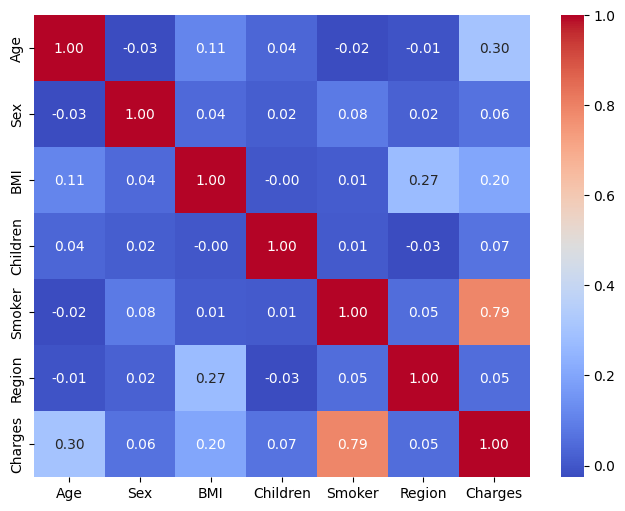

Charges     1.000000
Smoker      0.788783
Age         0.298624
BMI         0.199846
Children    0.066442
Sex         0.062837
Region      0.054058
Name: Charges, dtype: float64


In [4]:
# Correlation
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()
print(corr_matrix["Charges"].sort_values(ascending=False))

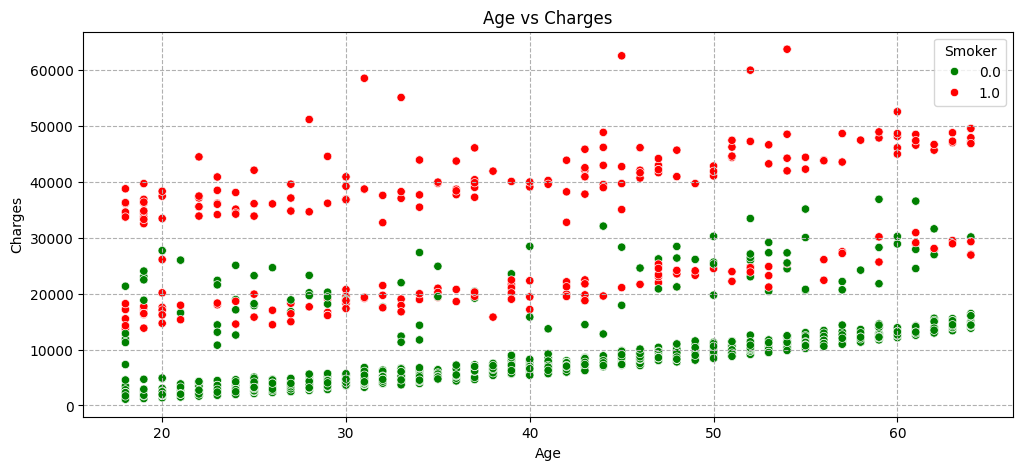

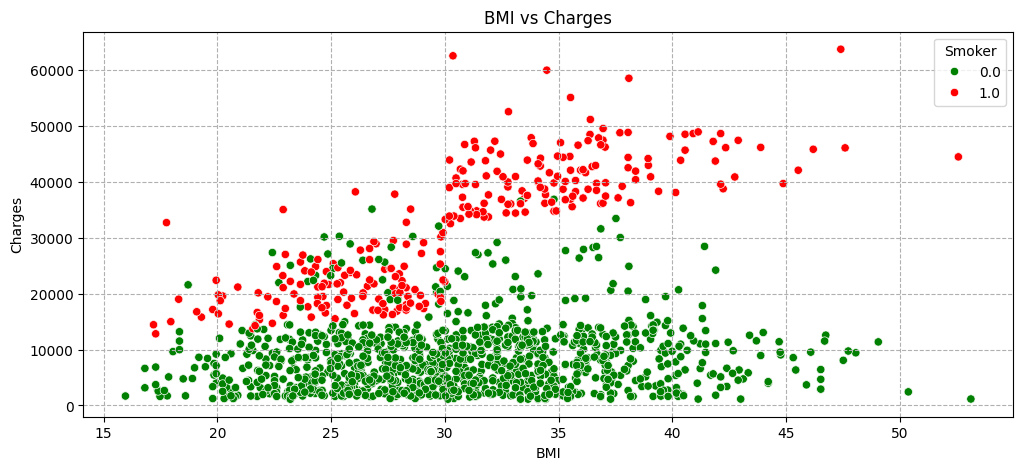

In [5]:
# Age vs Charges
plt.figure(figsize=(12, 5))
plt.grid(True, linestyle='--')
sns.scatterplot(x="Age", y="Charges", hue="Smoker", data=df, palette=["green", "red"])
plt.title("Age vs Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

# BMI vs Charges
plt.figure(figsize=(12, 5))
plt.grid(True, linestyle='--')
sns.scatterplot(x="BMI", y="Charges", hue="Smoker", data=df, palette=["green", "red"])
plt.title("BMI vs Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

In [6]:
# Data splitting and preprocessing pipeline
X = df.drop("Charges", axis=1)
y = df["Charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

numeric_features = ["Age", "BMI", "Children"]
categorical_features = ["Sex", "Smoker", "Region"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [7]:
# Train and evaluate multiple regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),  
    "KNeighbors": KNeighborsRegressor()
}

for name, model_instance in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model_instance)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name}:")
    print("R2:", round(r2_score(y_test, y_pred), 4))
    print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),'\n')

Linear Regression:
R2: 0.7399
MAE: 4121.44
RMSE: 6317.67 

Random Forest:
R2: 0.9521
MAE: 1271.41
RMSE: 2711.69 

XGBoost:
R2: 0.9571
MAE: 1131.74
RMSE: 2565.75 

Decision Tree:
R2: 0.939
MAE: 616.59
RMSE: 3059.77 

KNeighbors:
R2: 0.8149
MAE: 2832.66
RMSE: 5330.03 



In [8]:
# Hyperparameter tuning for XGBoost
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [3, 7],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [1, 2]
}

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb)
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}
R2: 0.9625
MAE: 830.94
RMSE: 2397.79


In [9]:
# Hyperparameter tuning for RandomForest
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [None, 7, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 0.8, 1.0]
}

pipeline = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", rf)
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'regressor__max_depth': None, 'regressor__max_features': 0.8, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
R2: 0.9524
MAE: 1281.62
RMSE: 2703.92


**Conclusions**

*Initial model benchmarking showed that tree-based models significantly outperformed linear and distance-based approaches:*

1. Linear Regression had the lowest performance (R² = 0.74, MAE ≈ 4121), which suggests it could not capture the nonlinear relationships in the data.

2. KNeighbors improved over Linear Regression but still lagged behind tree-based methods (R² = 0.81, MAE ≈ 2833).

3. Decision Tree, Random Forest, and XGBoost demonstrated high predictive power (R² > 0.93), with Decision Tree showing unusually low MAE on the test set but being more prone to overfitting.

*Hyperparameter tuning via GridSearchCV further improved results:*

1. XGBoost improved from R² = 0.9571 to 0.9625 and MAE ≈ 1131.74 to 0.9625, becoming the top-performing model in terms of both R² and MAE.

2. Random Forest showed minimal improvement after tuning, remaining at R² ≈ 0.9524, MAE ≈ 1281.62.

*Best model selection:*

XGBoost with tuned hyperparameters provided the best overall performance:

- R² = 0.9625 | explains ~96% of variance in the target variable.

- MAE = 830.94 | predictions deviate from the actual charges by ~6.3% of the mean target value (mean ≈ 13,261).

- RMSE = 2397.79 → relatively low considering the large target range (min ≈ 1,122, max ≈ 63,770).

**Final choice: Tuned XGBoost model for deployment or further optimization**